In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import netCDF4 as nc
import datetime as dt
from scipy.stats.distributions import t as scp_t
import scipy.stats as sst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from TPAR import PARfxns as pf
from TPAR import loadDataFRP as FRP
from TPAR import loadSTRATOGEM as STRAT
from TPAR import mplRC
%matplotlib inline

mpl default settings: fs=16, lw=1, ms=8


## Extract mid-depth transmissivity and plot for each cruise (to check for inter-cruise instrument variability) and by year day (to check for seasonal changes) 
    -develop QC procedure using per-cruise median mid-depth transmissivity as baseline

### LOAD STRATOGEM

In [3]:
df=STRAT.loadSTRATOGEM_XFP(qc=False,req=['xmiss'],calcs=['YD','cX'])
df.rename(columns={'cX':'cx_uncor'},inplace=True)

In [4]:
df['Bathy']=[pf.getBathy(r.Lon,r.Lat) for i,r in df.iterrows()]

load SSG


### remove inland station 216:

[-123.22316667   49.97166667  216.        ]


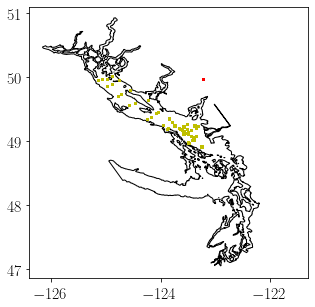

In [9]:
df2=df.loc[df.StaID==216]
fig,ax=plt.subplots(1,1,figsize=(5,5))
pf.quickMap(ax)
ax.plot(df.Lon,df.Lat,'y.',ms=2)
ax.plot(df2.Lon,df2.Lat,'r.',ms=2)
print(np.unique(df.loc[(df.Lon>-124.2)&(df.Lat>49.9),['StaID','Lat','Lon']]))

### load FRP

In [4]:
dfall=FRP.loadFlat(exp='all',sel='wide',dp=1.0,qc=False)
dfall.rename(columns={'turb':'NTU'},inplace=True)
dfall['cx_uncor']=FRP.cXfromX(dfall['xmiss'])
dfall['Bathy']=[pf.getBathy(r.Lon,r.Lat) for i,r in dfall.iterrows()]

### look at difference from profile maximum versus depth to choose depth range to use to calculate offset

In [5]:
#add difference from maximum value in each cast with bathy>150m as 'difmax'
df['difmax']=np.nan
for ic in np.unique(df['StaID']):
    idf=df.loc[df.StaID==ic]
    # calc difference from maximum, but only at stations with bathy > 150
    if idf['Bathy'].values[0]>150:
        for ind, row in idf.iterrows():
            df.at[ind,'difmax']=df.loc[ind,['xmiss']]-np.nanmax(idf['xmiss'])

In [6]:
dfall['difmax']=np.nan
for ic in np.unique(dfall['castid']):
    idf=dfall.loc[dfall.castid==ic]
    # calc difference from maximum, but only at stations with bathy > 150
    if idf['Bathy'].values[0]>150:
        for ind, row in idf.iterrows():
            dfall.at[ind,'difmax']=dfall.loc[ind,['xmiss']]-np.nanmax(idf['xmiss'])

In [7]:
### try restricing to central strait

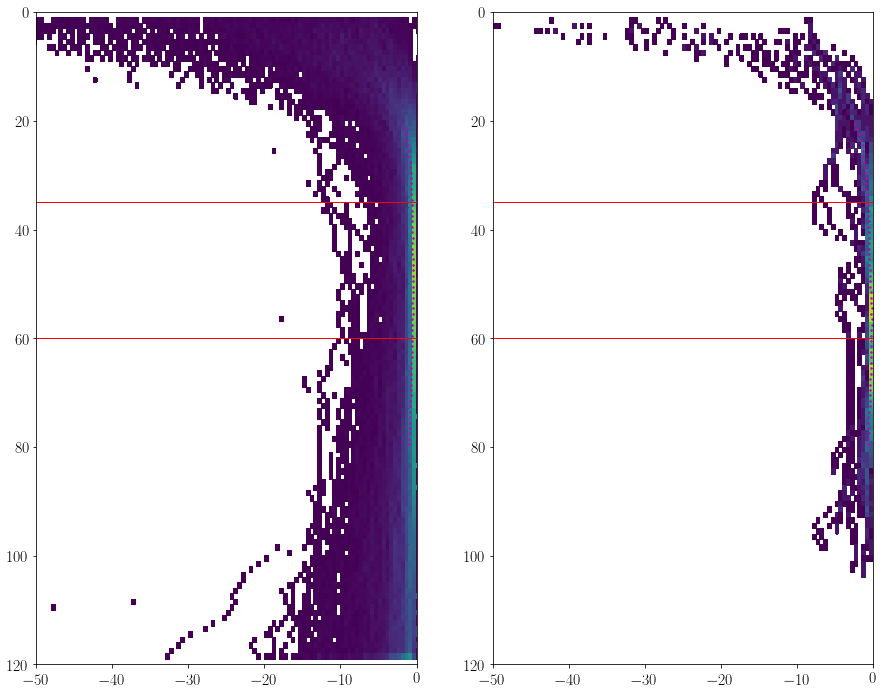

In [8]:
#2d hist of depth vs (xmiss -max profile xmiss), for choosing depth to use as reference:
fig,ax=plt.subplots(1,2,figsize=(15,12))

ii=(~pd.isnull(df['difmax']))&(~pd.isnull(df['prSM']))
counts, xedges, yedges, m1=ax[0].hist2d(df.loc[ii,['difmax']].values.flatten(),
                                      df.loc[ii,['prSM']].values.flatten(),[np.arange(-120,1,.5),np.arange(0,120)],
                                        cmin=1,cmax=250,vmin=1,vmax=250);
for zz in range(20,80):
    ii=(~pd.isnull(df['difmax']))&(df['prSM']>=zz)&(df['prSM']<(zz+1))
    ax[0].plot(np.median(df.loc[ii,['difmax']]),zz+.5,'m.',ms=3)

ii=(~pd.isnull(dfall['difmax']))&(~pd.isnull(dfall['prSM']))
counts, xedges, yedges, m1=ax[1].hist2d(dfall.loc[ii,['difmax']].values.flatten(),
                                      dfall.loc[ii,['prSM']].values.flatten(),[np.arange(-120,1,.5),np.arange(0,120)],
                                        cmin=1,cmax=20,vmin=1,vmax=20);
for zz in range(20,80):
    ii=(~pd.isnull(dfall['difmax']))&(dfall['prSM']>=zz)&(dfall['prSM']<(zz+1))
    ax[1].plot(np.median(dfall.loc[ii,['difmax']]),zz+.5,'m.',ms=3)
    
for iax in ax:
    iax.set_ylim(120,0)
    iax.set_xlim(-50,0)
    iax.axhline(35,color='r')
    iax.axhline(60,color='r')

### restrict to central strait:

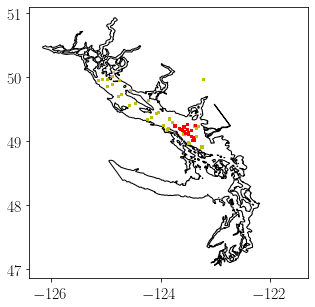

In [9]:
dfcs=df.loc[(df.Lat>48.5)&(df.Lat<49.3)&(df.Bathy>250)]
fig,ax=plt.subplots(1,1,figsize=(5,5))
pf.quickMap(ax)
ax.plot(df.Lon,df.Lat,'y.',ms=2)
ax.plot(dfcs.Lon,dfcs.Lat,'r.',ms=2)

45m: -0.4566999999999979 -0.5719120086251337
35-55m: -0.482999999999997 -0.4398671605959663 -0.4398671605959663
35-65m: -0.4869499999999931 -0.37298273229819756
35-75m: -0.5130999999999943 -0.38531044670254033
40-60m: -0.4691999999999936 -0.3533827335435973
40-65m: -0.4819999999999993 -0.3404890863170138
50-70m: -0.5078999999999994 -0.29056100600631396


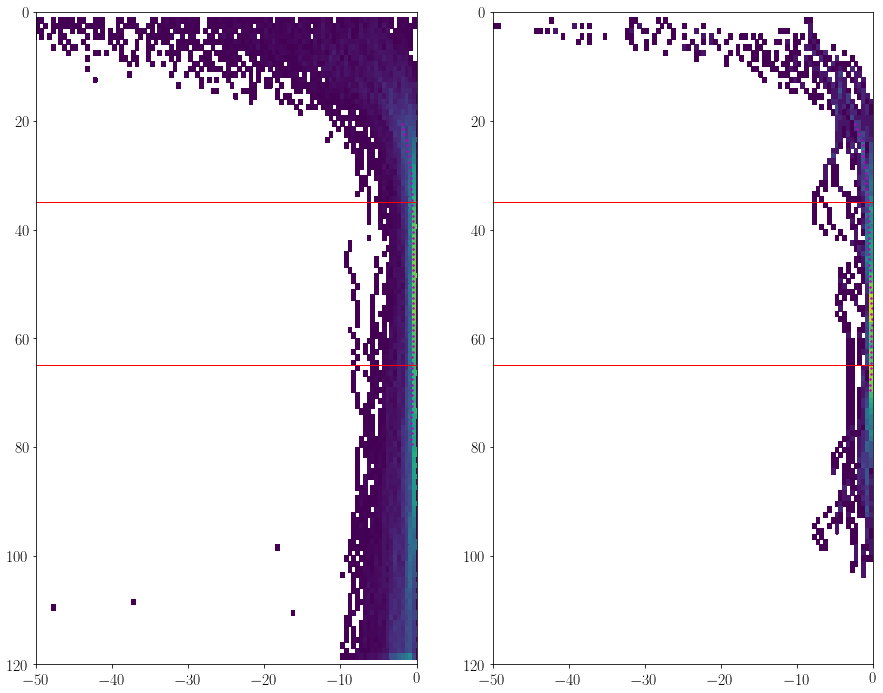

In [10]:
# constraing to central strait
#2d hist of depth vs (xmiss -max profile xmiss), for choosing depth to use as reference:
fig,ax=plt.subplots(1,2,figsize=(15,12))

ii=(~pd.isnull(dfcs['difmax']))&(~pd.isnull(dfcs['prSM']))
counts, xedges, yedges, m1=ax[0].hist2d(dfcs.loc[ii,['difmax']].values.flatten(),
                                      dfcs.loc[ii,['prSM']].values.flatten(),[np.arange(-120,1,.5),np.arange(0,120)],
                                        cmin=1,cmax=150,vmin=1,vmax=150);
for zz in range(20,80):
    ii=(~pd.isnull(df['difmax']))&(dfcs['prSM']>=zz)&(dfcs['prSM']<(zz+1))
    ax[0].plot(np.median(dfcs.loc[ii,['difmax']]),zz+.5,'m.',ms=3)

ii=(~pd.isnull(dfall['difmax']))&(~pd.isnull(dfall['prSM']))
counts, xedges, yedges, m1=ax[1].hist2d(dfall.loc[ii,['difmax']].values.flatten(),
                                      dfall.loc[ii,['prSM']].values.flatten(),[np.arange(-120,1,.5),np.arange(0,120)],
                                        cmin=1,cmax=20,vmin=1,vmax=20);
for zz in range(20,70):
    ii=(~pd.isnull(dfall['difmax']))&(dfall['prSM']>=zz)&(dfall['prSM']<(zz+1))
    ax[1].plot(np.median(dfall.loc[ii,['difmax']]),zz+.5,'m.',ms=3)
    
for iax in ax:
    iax.set_ylim(120,0)
    iax.set_xlim(-50,0)
    iax.axhline(35,color='r')
    iax.axhline(65,color='r')
print('45m:',np.median(dfcs.loc[(dfcs.prSM>=45)&(dfcs.prSM<46),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=45)&(dfall.prSM<46),['difmax']]))
print('35-55m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<55),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=35)&(dfall.prSM<55),['difmax']]),
     np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=35)&(dfall.prSM<55),['difmax']],50))
print('35-65m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<65),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=35)&(dfall.prSM<65),['difmax']]))
print('35-75m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<75),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=35)&(dfall.prSM<75),['difmax']]))
print('40-60m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=40)&(dfcs.prSM<60),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=40)&(dfall.prSM<60),['difmax']]))
print('40-65m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=40)&(dfcs.prSM<65),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=40)&(dfall.prSM<65),['difmax']]))
print('50-70m:',np.nanmedian(dfcs.loc[(dfcs.prSM>=50)&(dfcs.prSM<70),['difmax']]),
      np.nanmedian(dfall.loc[(dfall.prSM>=50)&(dfall.prSM<70),['difmax']]))

### try looking at 80th percentile (high values are near minimum) rather than median (50th):

In [11]:
print('45m:',np.percentile(dfcs.loc[(dfcs.prSM>=45)&(dfcs.prSM<46),['difmax']],np.arange(0,100,5)))

45m: [-9.1524  -2.42725 -1.5564  -1.26036 -1.15624 -0.9912  -0.85792 -0.74343
 -0.62796 -0.52946 -0.4567  -0.39347 -0.3445  -0.2943  -0.23106 -0.1991
 -0.1683  -0.11814 -0.07928 -0.03809]


In [12]:
print('45m:',np.percentile(dfcs.loc[(dfcs.prSM>=45)&(dfcs.prSM<46),['difmax']],np.arange(0,100,5)))

45m: [-9.1524  -2.42725 -1.5564  -1.26036 -1.15624 -0.9912  -0.85792 -0.74343
 -0.62796 -0.52946 -0.4567  -0.39347 -0.3445  -0.2943  -0.23106 -0.1991
 -0.1683  -0.11814 -0.07928 -0.03809]


In [13]:
print('45m:',np.percentile(dfcs.loc[(dfcs.prSM>=45)&(dfcs.prSM<46),['difmax']],np.arange(0,100,5)))

45m: [-9.1524  -2.42725 -1.5564  -1.26036 -1.15624 -0.9912  -0.85792 -0.74343
 -0.62796 -0.52946 -0.4567  -0.39347 -0.3445  -0.2943  -0.23106 -0.1991
 -0.1683  -0.11814 -0.07928 -0.03809]


In [14]:

print('45m:',np.percentile(dfcs.loc[(dfcs.prSM>=45)&(dfcs.prSM<46),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=45)&(dfall.prSM<46),['difmax']],80))
print('35-55m:',np.percentile(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<55),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=35)&(dfall.prSM<55),['difmax']],80))
print('35-65m:',np.percentile(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<65),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=35)&(dfall.prSM<65),['difmax']],80))
print('35-75m:',np.percentile(dfcs.loc[(dfcs.prSM>=35)&(dfcs.prSM<75),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=35)&(dfall.prSM<75),['difmax']],80))
print('40-60m:',np.percentile(dfcs.loc[(dfcs.prSM>=40)&(dfcs.prSM<60),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=40)&(dfall.prSM<60),['difmax']],80))
print('40-65m:',np.percentile(dfcs.loc[(dfcs.prSM>=40)&(dfcs.prSM<65),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=40)&(dfall.prSM<65),['difmax']],80))
print('50-70m:',np.percentile(dfcs.loc[(dfcs.prSM>=50)&(dfcs.prSM<70),['difmax']],80),
      np.percentile(dfall.loc[(~np.isnan(dfall['difmax']))&(dfall.prSM>=50)&(dfall.prSM<70),['difmax']],80))

45m: -0.16829999999999642 -0.17693710091977266
35-55m: -0.17319999999999708 -0.17200713854714417
35-65m: -0.16742000000000132 -0.13175478791677617
35-75m: -0.17501999999999782 -0.13338959531697298
40-60m: -0.16353999999999755 -0.1335900338898085
40-65m: -0.16161999999999352 -0.12811929553947715
50-70m: -0.16706000000000068 -0.09995068036716065


## for now, use 40-60m as depth range and median (50th percentile)

### extract 40-60 m median and offset xmiss: xmissOS

In [15]:
df['xmissOS']=np.nan
for icr in np.unique(df['Cruise']):
    idfcr=df.loc[(df.Cruise==icr)]
    if np.max(idfcr.Depth)<200:
        print(icr,np.max(idfcr.Depth))
    idf4060=idfcr.loc[(idfcr.Depth>40)&(idfcr.Depth<60)]
    offset=np.median(idf4060['xmiss'])
    for ind, row in idfcr.iterrows():
        df.at[ind,'xmissOS']=df.loc[ind,['xmiss']]+100-offset

SG02-01 11/April/02 118.94481136399254
SG02-02  8/May/02 118.94481136399254
SOG02-03 5/June/2002 118.94481136399254
SOG02-04 10/July/2002 118.94481136399254
SOG02-05 17/July/2002 118.94481136399254
SOG02-06 07/August/2002 83.2686266910891
SOG02-06 7/August/2002 118.94481136399254
SOG02-07 29/Aug/2002 118.94481136399254
SOG02-08 8/Oct/2002 118.94481136399254
SOG02-08 8/October/2002 118.94481136399254
SOG02-09 5/Nov/2002 118.94481136399254
SOG02-10 4/Dec/2002 118.94481136399254
SOG03-01 8/Jan/2003 118.94481136399254
SOG03-02 5/Feb/2003 118.94481136399254
SOG03-03 5/Mar/2003 118.94481136399254
SOG03-04 19/Mar/2003 118.94481136399254
SOG03-05 2/Apr/2003 118.94481136399254
SOG03-06 9/Apr/2003 118.94481136399254
SOG03-07 16/Apr/2003 118.94481136399254
SOG03-08 23/Apr/2003 118.94481136399254
SOG03-09 28/May/2003 118.94481136399254
SOG03-10 19 /June/2003 118.94481136399254
SOG03-11 23/June/2003 118.94481136399254
SOG03-12 26 /June/2003 118.94481136399254
SOG03-13 30/Jun/2003 118.94481136399254

In [16]:
df.loc[df.Cruise=='SoG 03-17 28/Aug/2003']

,StaID,prSM,Depth,xmiss,wetStar,sal00,t090C,par,Cruise,StName,...,Time,xcal0,xcal1,xcal2,xcalFile,YD,cx_uncor,Bathy,difmax,xmissOS
26189,214,1.0,0.991493,-4.9195,-1.0576,27.0229,16.7747,35.4590,SoG 03-17 28/Aug/2003,F1,...,07:54,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,NaN,247.6875,-101.8241,-1.7620
26190,214,2.0,1.982980,53.1605,4.0260,27.9033,16.7775,29.2580,SoG 03-17 28/Aug/2003,F1,...,07:54,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,2.527418,247.6875,-43.7441,56.3180
26191,214,3.0,2.974463,82.7885,6.6613,27.7249,16.7731,19.0130,SoG 03-17 28/Aug/2003,F1,...,07:54,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.755524,247.6875,-14.1161,85.9460
26192,214,4.0,3.965942,80.9140,6.5373,27.7188,16.7824,12.7130,SoG 03-17 28/Aug/2003,F1,...,07:54,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.847133,247.6875,-15.9906,84.0715
26193,214,5.0,4.957415,80.8873,6.7261,27.7228,16.7795,10.3410,SoG 03-17 28/Aug/2003,F1,...,07:54,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.848453,247.6875,-16.0173,84.0448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26528,222,36.0,35.690706,97.3693,0.1512,29.4459,10.3106,4.2002,SoG 03-17 28/Aug/2003,F8,...,12:28,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.106637,50.6250,NaN,100.5268
26529,222,37.0,36.682025,97.4194,0.1521,29.4490,10.3011,4.2062,SoG 03-17 28/Aug/2003,F8,...,12:28,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.104579,50.6250,NaN,100.5769
26530,222,38.0,37.673340,97.3933,0.1605,29.4530,10.2909,4.1654,SoG 03-17 28/Aug/2003,F8,...,12:28,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.105651,50.6250,NaN,100.5508
26531,222,39.0,38.664650,97.4598,0.1565,29.4571,10.2801,4.1550,SoG 03-17 28/Aug/2003,F8,...,12:28,22.158,-1.285,0.25,/ocean/shared/SoG/ctd/03-17/sbe25process.con,240.0,0.102921,50.6250,NaN,100.6173


In [17]:
df4060=df.loc[(df.Depth>60)&(df.Depth<70)]

In [18]:
dfsurf=df.loc[df.Depth<10]

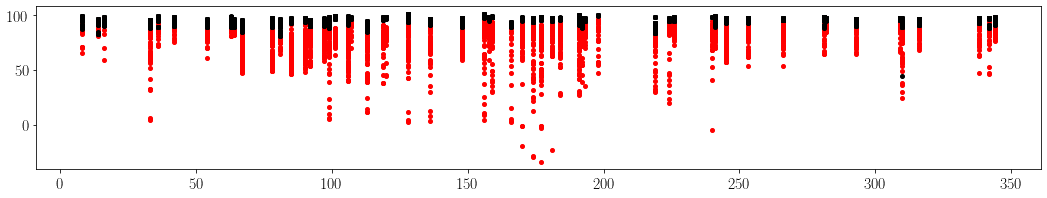

In [19]:
fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(dfsurf['YD'],dfsurf['xmiss'],'r.')
ax.plot(df4060['YD'],df4060['xmiss'],'k.')

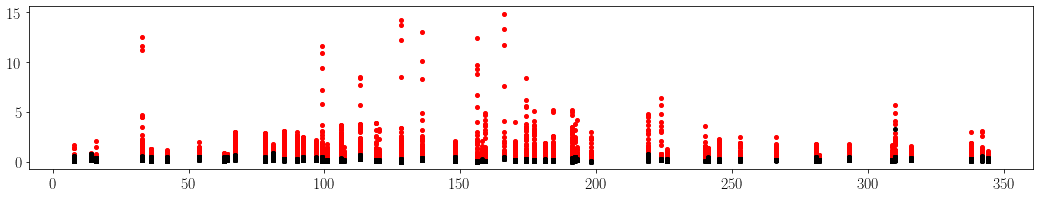

In [20]:
fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(dfsurf['YD'],dfsurf['cx_uncor'],'r.')
ax.plot(df4060['YD'],df4060['cx_uncor'],'k.')

In [21]:
df['xmissOS']

0        80.86415
1        80.05715
2        83.53485
3        84.93475
4        87.59775
           ...   
57951    98.59950
57952    98.57340
57953    98.54250
57954    98.59210
57955    98.53040
Name: xmissOS, Length: 57956, dtype: float64

In [22]:
df.loc[np.isnan(df.Bathy),['Lon','Lat']].drop_duplicates()

,Lon,Lat
3927,NaN,NaN
22962,NaN,49.026167
23201,NaN,49.092517
23439,NaN,49.131867
23678,NaN,49.215633
23916,NaN,49.249583
24153,NaN,49.303833
26290,-123.223167,49.971667


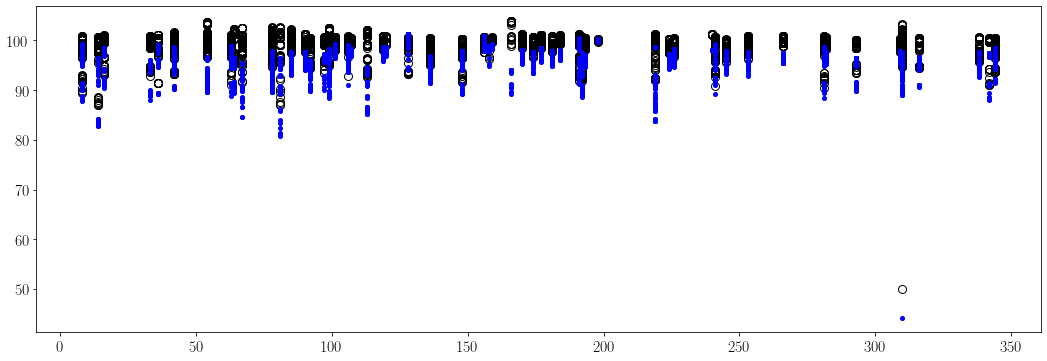

In [23]:
fig,ax=plt.subplots(1,1,figsize=(18,6))
#ax.plot(dfsurf['YD'],dfsurf['xmissOS'],'r.')
ax.plot(df4060['YD'],df4060['xmissOS'],'ko',fillstyle='none')
ax.plot(df4060['YD'],df4060['xmiss'],'b.')

In [24]:
df.keys()

Index(['StaID', 'prSM', 'Depth', 'xmiss', 'wetStar', 'sal00', 't090C', 'par',
       'Cruise', 'StName', 'Lat', 'Lon', 'Year', 'Mon', 'Day', 'Time', 'xcal0',
       'xcal1', 'xcal2', 'xcalFile', 'YD', 'cx_uncor', 'Bathy', 'difmax',
       'xmissOS'],
      dtype='object')

### Look at effect of variations in instrument calibration

In [25]:
np.unique(df['xcal0'])

array([21.1811, 21.7594, 22.1297, 22.158 , 22.302 ])

In [26]:
np.unique(df['xcal1'])

array([-1.5232, -1.285 , -1.1947, -1.1523,  1.2043,  1.2285,  1.285 ])

In [27]:
np.unique(df['xcal2'])

array([0.25])

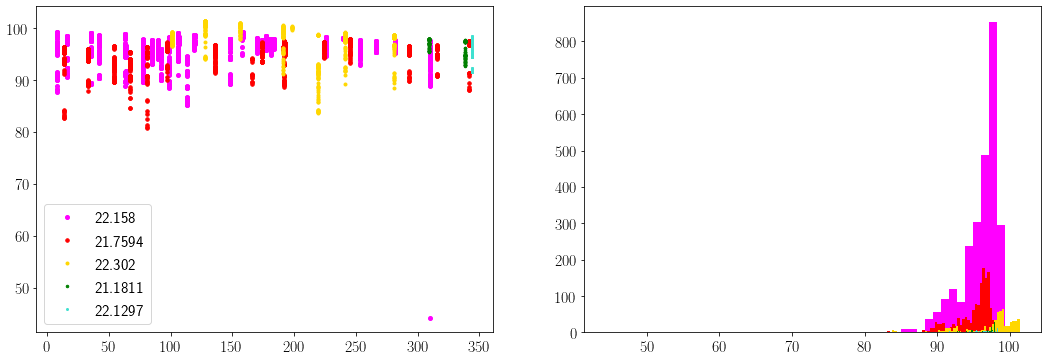

In [28]:
#divide by calibration:
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,2,figsize=(18,6))
for ii,ical in enumerate([22.158 , 21.7594,  22.302,21.1811, 22.1297, ]):#np.unique(df['xcal0'])):
    idf=df4060.loc[df4060.xcal0==ical]
    ax[0].plot(idf['YD'],idf['xmiss'],'.',color=colors[ii],ms=8-ii,label=ical)
    ax[0].legend()
    ax[1].hist(idf['xmiss'],50,color=colors[ii])

In [29]:
# What happens if apply same cal to all?
m1=22.1580
b1=-1.2850
#t=m0*v+b0
#(t-b0)/m0=v
#newt=m1/m0*(t-b0)+b1
df['xmiss_1cal']=[m1/r.xcal0*(r.xmiss-r.xcal1)+b1 for ind, r in df.iterrows()]

In [30]:
df4060=df.loc[(df.Depth>60)&(df.Depth<70)]

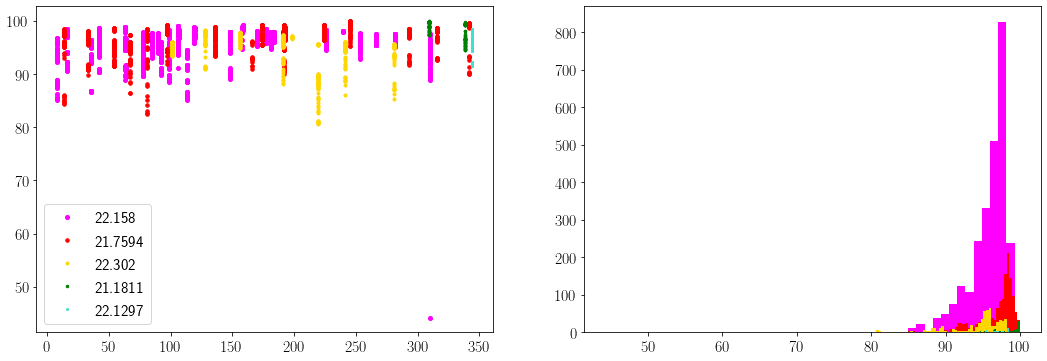

In [31]:

fig,ax=plt.subplots(1,2,figsize=(18,6))
for ii,ical in enumerate([22.158 ,  21.7594, 22.302,21.1811, 22.1297, ]):#np.unique(df['xcal0'])):
    idf=df4060.loc[df4060.xcal0==ical]
    ax[0].plot(idf['YD'],idf['xmiss_1cal'],'.',color=colors[ii],ms=8-ii,label=ical)
    ax[0].legend()
    ax[1].hist(idf['xmiss_1cal'],50,color=colors[ii])

In [32]:
dfall.keys()

Index(['prSM', 'gsw_ctA0', 'gsw_srA0', 'xmiss', 'par', 'wetStar', 'sbeox0ML_L',
       'seaTurbMtrnoQC', 'turb_uncor', 'NTU', 'CStarTr0', 'wetStar19', 'isup',
       'sta', 'castid', 'Station', 'Date', 'Lat', 'Lon', 'cX', 'cx_uncor',
       'Bathy', 'difmax'],
      dtype='object')

In [33]:
dfall['xmissOS']=np.nan
for icr in np.unique(dfall['Date']):
    idfcr=dfall.loc[(dfall.Date==icr)]
    idf4060=idfcr.loc[(idfcr.prSM>40)&(idfcr.prSM<60)]
    offset=np.median(idf4060['xmiss'])
    print(icr,offset)
    for ind, row in idfcr.iterrows():
        dfall.at[ind,'xmissOS']=dfall.loc[ind,['xmiss']]+100-offset

20170410 96.05089978745418
20170531 94.93578708620461
20171101 93.22602867915398


In [34]:
dfall4060=dfall.loc[(dfall.prSM>40)&(dfall.prSM<60)]

In [35]:
np.unique(dfall['Date'])

array([20170410, 20170531, 20171101])

<ipython-input-36-546b63657099>:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(SSG.navlon,SSG.navlat,SSG.bathy,shading='nearest')


some FRP data points  are shallower than 100m


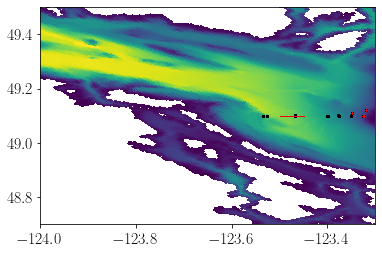

In [36]:
### map station locations, FRP:
SSG=pf.SSCGrid()
plt.pcolormesh(SSG.navlon,SSG.navlat,SSG.bathy,shading='nearest')
plt.plot(dfall4060.Lon,dfall4060.Lat,'k.',ms=2)
ii=dfall4060.Bathy>150
plt.plot(dfall4060.loc[~ii,['Lon']],dfall4060.loc[~ii,['Lat']],'r.',ms=1)
plt.xlim(-124,-123.3)#2.75)
plt.ylim(48.7,49.5)
plt.plot((-123.5,-123.45),(49.1,49.1),'r-')
print('some FRP data points  are shallower than 100m')

sb25 xmiss 40-60m, z>100
20170531 Median: 95.56
20170410 Median: 96.28
20171101 Median: 93.48


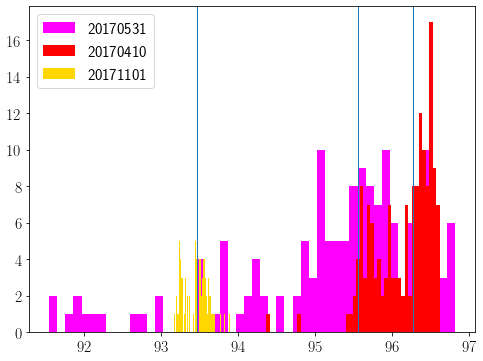

In [37]:
#divide by date:
print('sb25 xmiss 40-60m, z>100')
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>200)]
    ax.hist(idf['xmiss'],50,color=colors[ii],label=ical)
    ax.legend()
    print(f'{ical} Median: {np.median(idf.xmiss):.2f}')
    ax.axvline(np.median(idf.xmiss))

<ipython-input-38-fd59c12de2c9>:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(SSG.navlon,SSG.navlat,SSG.bathy,shading='nearest')


(49.0, 50.0)

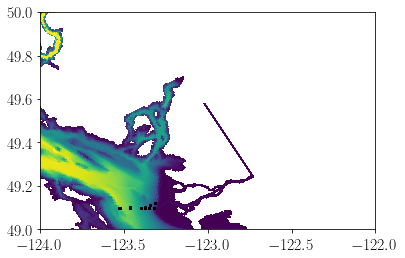

In [38]:
plt.pcolormesh(SSG.navlon,SSG.navlat,SSG.bathy,shading='nearest')
plt.plot(dfall4060.Lon,dfall4060.Lat,'k.',ms=2)
ii=(dfall4060.Bathy>250)&(dfall4060.xmiss<92)
plt.plot(dfall4060.loc[ii,['Lon']],dfall4060.loc[ii,['Lat']],'r.',ms=1)
plt.xlim(-124,-122)
plt.ylim(49,50)

sb25 xmiss 40-60m, single deep station
20170531 Median: 96.04
20170410 Median: 95.67
20171101 Median: 93.56


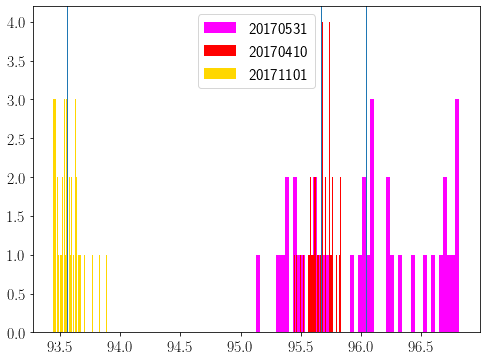

In [39]:
#divide by date:
print('sb25 xmiss 40-60m, single deep station')
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>100)&\
                     (dfall4060.Lon>-123.5)&(dfall4060.Lon<-123.45)]
    ax.hist(idf['xmiss'],50,color=colors[ii],label=ical)
    ax.legend()
    print(f'{ical} Median: {np.median(idf.xmiss):.2f}')
    ax.axvline(np.median(idf.xmiss))

sb19 CStarTr0 40-60m, z>100
20170531 Median: 85.00
20170410 Median: 85.82
20171101 Median: 85.65


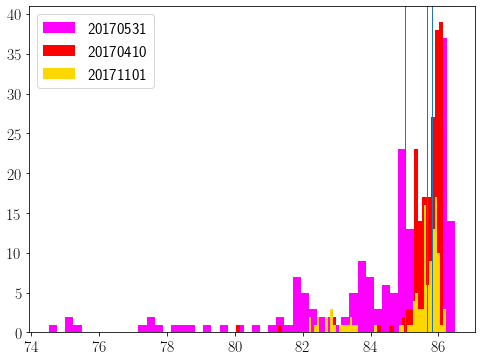

In [40]:
#divide by date:
print('sb19 CStarTr0 40-60m, z>100')
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>100)]
    ax.hist(idf['CStarTr0'],50,color=colors[ii],label=ical)
    ax.legend()
    print(f'{ical} Median: {np.median(idf.CStarTr0):.2f}')
    ax.axvline(np.median(idf.CStarTr0))

sb19 xmiss 40-60m, single deep station
20170531 Median: 86.06
20170410 Median: 85.38
20171101 Median: 85.94


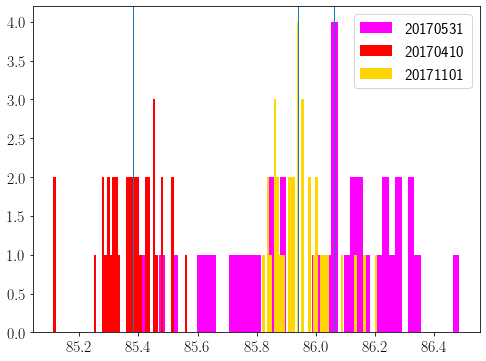

In [41]:
#divide by date:
print('sb19 xmiss 40-60m, single deep station')
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>100)&\
                     (dfall4060.Lon>-123.5)&(dfall4060.Lon<-123.45)]
    ax.hist(idf['CStarTr0'],50,color=colors[ii],label=ical)
    ax.legend()
    print(f'{ical} Median: {np.median(idf.CStarTr0):.2f}')
    ax.axvline(np.median(idf.CStarTr0))

Text(0, 0.5, 'sb25 xmiss')

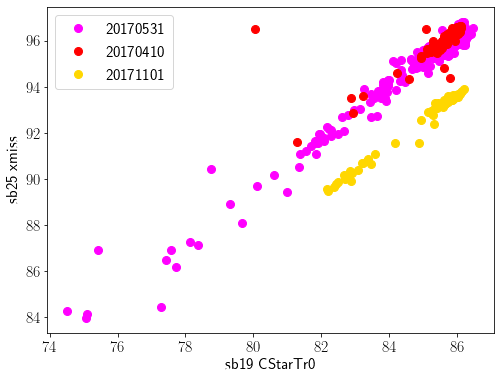

In [42]:
#divide by date:
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>100)]
    ax.plot(idf['CStarTr0'],idf['xmiss'],'o',color=colors[ii],label=ical)
    ax.legend()
ax.set_xlabel('sb19 CStarTr0')
ax.set_ylabel('sb25 xmiss')

In [43]:
FRP.cXfromX([93]),FRP.cXfromX([95]),FRP.cXfromX([98])

(array([0.29028277]), array([0.20517318]), array([0.08081083]))

In [44]:
.29-.08

0.20999999999999996

In [45]:
FRP.cXfromX([73]),FRP.cXfromX([75]),FRP.cXfromX([78])

(array([1.25884298]), array([1.15072829]), array([0.99384544]))

In [46]:
1.25884298-0.99384544

0.2649975400000001

In [47]:
FRP.cXfromX([43]),FRP.cXfromX([45]),FRP.cXfromX([48])

(array([3.37588028]), array([3.19403078]), array([2.9358767]))

In [48]:
3.37588028-2.9358767

0.44000357999999995

In [49]:
np.median(df.loc[(df.Depth>60)&(df.Depth<80),['xmiss']])

96.4406

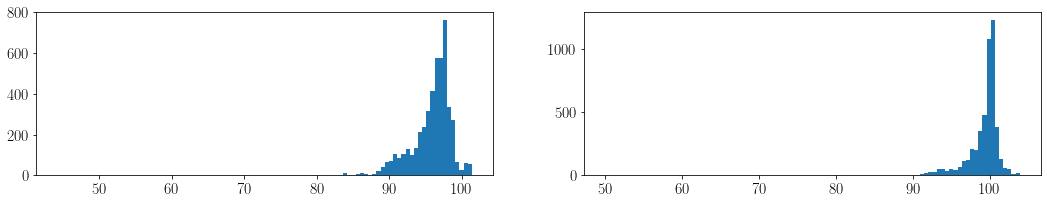

In [50]:
fig,ax=plt.subplots(1,2,figsize=(18,3))
ax[0].hist(df.loc[(df.Depth>60)&(df.Depth<70),['xmiss']],100);
ax[1].hist(df.loc[(df.Depth>60)&(df.Depth<70),['xmissOS']],100);

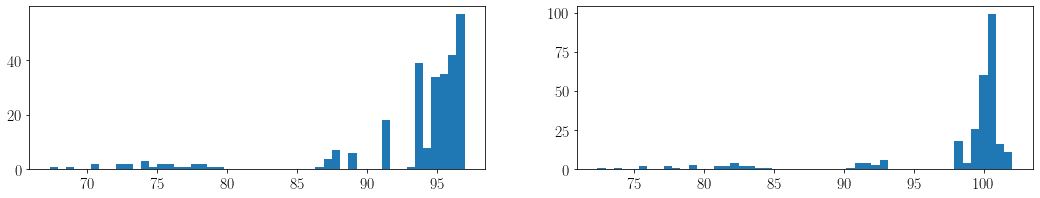

In [51]:
fig,ax=plt.subplots(1,2,figsize=(18,3))
ax[0].hist(dfall.loc[(dfall.prSM>60)&(dfall.prSM<70),['xmiss']],50);
ax[1].hist(dfall.loc[(dfall.prSM>60)&(dfall.prSM<70),['xmissOS']],50);

In [52]:
df['cX']=FRP.cXfromX(df['xmissOS'])
dfall['cX']=FRP.cXfromX(dfall['xmissOS'])

Text(0.5, 1.0, 'STRAT after QC cX')

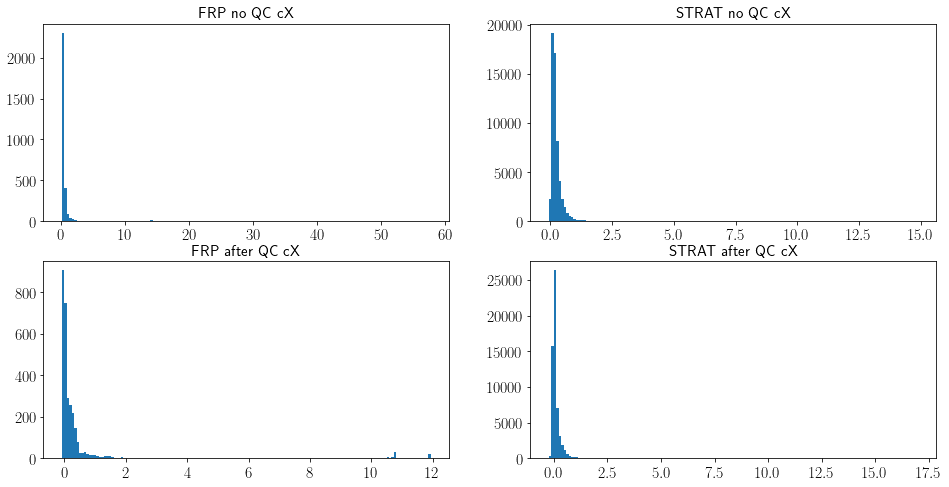

In [53]:
fig,ax=plt.subplots(2,2,figsize=(16,8))
ax=ax.flatten()
ax[0].hist(dfall['cx_uncor'],150);
ax[0].set_title('FRP no QC cX')
ax[1].hist(df['cx_uncor'],150);
ax[1].set_title('STRAT no QC cX')
ax[2].hist(dfall['cX'],150);
ax[2].set_title('FRP after QC cX')
ax[3].hist(df['cX'],150);
ax[3].set_title('STRAT after QC cX')

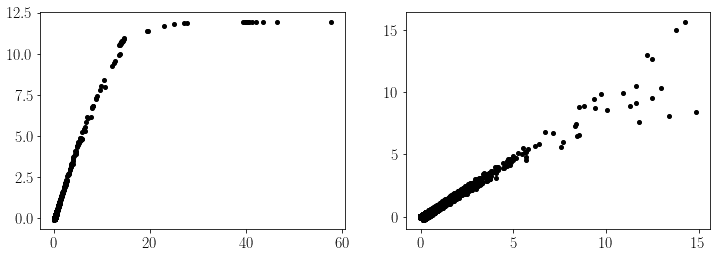

In [54]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(dfall['cx_uncor'],dfall['cX'],'k.');
ax[1].plot(df['cx_uncor'],df['cX'],'k.');

Text(0, 0.5, 'new xmiss')

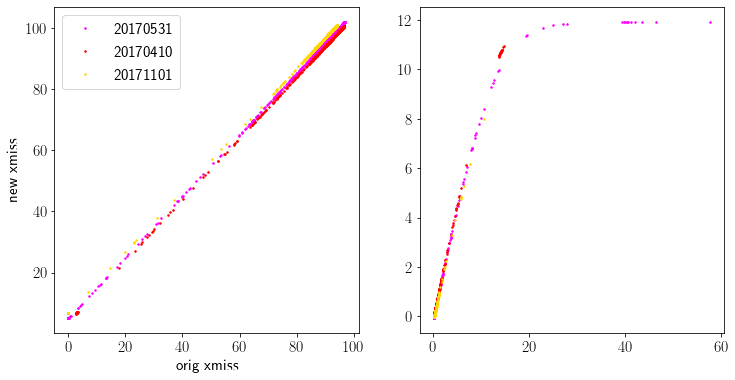

In [55]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall.loc[(dfall.Date==ical)]
    ax[0].plot(idf['xmiss'],idf['xmissOS'],'.',color=colors[ii],label=ical,ms=3)
    ax[1].plot(FRP.cXfromX(idf['xmiss']),FRP.cXfromX(idf['xmissOS']),'.',color=colors[ii],label=ical,ms=3)
ax[0].legend()
ax[0].set_xlabel('orig xmiss')
ax[0].set_ylabel('new xmiss')

In [56]:
#test new qc fun!!!

In [57]:
np.sum(~np.isnan(df.xmiss))

57956

In [58]:
df2=df.copy(deep=True)

In [59]:
df2.keys()

Index(['StaID', 'prSM', 'Depth', 'xmiss', 'wetStar', 'sal00', 't090C', 'par',
       'Cruise', 'StName', 'Lat', 'Lon', 'Year', 'Mon', 'Day', 'Time', 'xcal0',
       'xcal1', 'xcal2', 'xcalFile', 'YD', 'cx_uncor', 'Bathy', 'difmax',
       'xmissOS', 'xmiss_1cal', 'cX'],
      dtype='object')

In [60]:
df2['Bathy']=[pf.getBathy(r['Lon'],r['Lat']) for i,r in df2.iterrows()]

In [61]:
#import importlib

In [62]:
#import PARfxns

In [63]:
#importlib.reload(PARfxns)

In [64]:
pf.xmissQCFlat(df2,depthvar='prSM',castvar='StaID')

SG02-01 11/April/02 1.6227499999999964
SG02-02  8/May/02 -0.6704500000000024
SOG02-03 5/June/2002 -0.2139500000000112
SOG02-04 10/July/2002 0.5047999999999888
SOG02-05 17/July/2002 -0.03340000000000032
SOG02-06 07/August/2002 1.3174999999999955
SOG02-06 7/August/2002 8.0942
SOG02-07 29/Aug/2002 0.8496999999999986
SOG02-08 8/Oct/2002 1.842100000000002
SOG02-08 8/October/2002 1.5545999999999935
SOG02-09 5/Nov/2002 2.288749999999993
SOG02-10 4/Dec/2002 2.5351500000000016
SOG03-01 8/Jan/2003 1.9637500000000045
SOG03-02 5/Feb/2003 2.0537499999999937
SOG03-03 5/Mar/2003 5.672150000000002
SOG03-04 19/Mar/2003 7.4773
SOG03-05 2/Apr/2003 4.46905000000001
SOG03-06 9/Apr/2003 6.000550000000004
SOG03-07 16/Apr/2003 4.312150000000003
SOG03-08 23/Apr/2003 6.894599999999997
SOG03-09 28/May/2003 2.457250000000002
SOG03-10 19 /June/2003 3.2700999999999993
SOG03-11 23/June/2003 3.0463000000000022
SOG03-12 26 /June/2003 2.7757000000000005
SOG03-14 3 /July/2003 3.1513999999999953
SOG03-19 23/Sep/2003 3.07

In [65]:
dfall.keys()

Index(['prSM', 'gsw_ctA0', 'gsw_srA0', 'xmiss', 'par', 'wetStar', 'sbeox0ML_L',
       'seaTurbMtrnoQC', 'turb_uncor', 'NTU', 'CStarTr0', 'wetStar19', 'isup',
       'sta', 'castid', 'Station', 'Date', 'Lat', 'Lon', 'cX', 'cx_uncor',
       'Bathy', 'difmax', 'xmissOS'],
      dtype='object')

In [66]:
pf.xmissQCFlat(dfall,xmissvar='xmiss',groupingvar='Date',castvar='castid',depthvar='prSM',latvar='Lat',lonvar='Lon')

20170410 3.8876330419125793
20170531 4.548945890945674
20171101 6.538724156994277


In [67]:
pf.xmissQCFlat(dfall,xmissvar='CStarTr0',groupingvar='Date',castvar='castid',depthvar='prSM',latvar='Lat',lonvar='Lon')

20170410 14.292515313550624
20170531 14.706765305014343
20171101 14.207159748668289


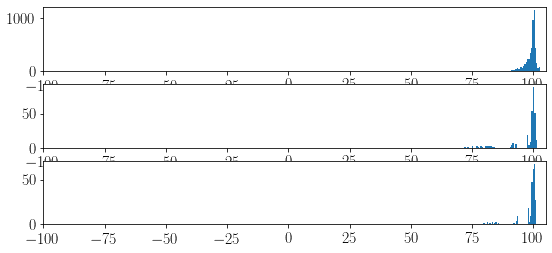

In [68]:
fig,ax=plt.subplots(3,1,figsize=(9,4))
ax[0].hist(df2.loc[(df2.Depth>60)&(df2.Depth<70),['xmiss']],100);
ax[1].hist(dfall.loc[(dfall.prSM>60)&(dfall.prSM<70),['xmiss']],50);
ax[2].hist(dfall.loc[(dfall.prSM>60)&(dfall.prSM<70),['CStarTr0']],50);
for iax in ax:
    iax.set_xlim(-100,105)

Text(0.5, 1.0, '40-60 m')

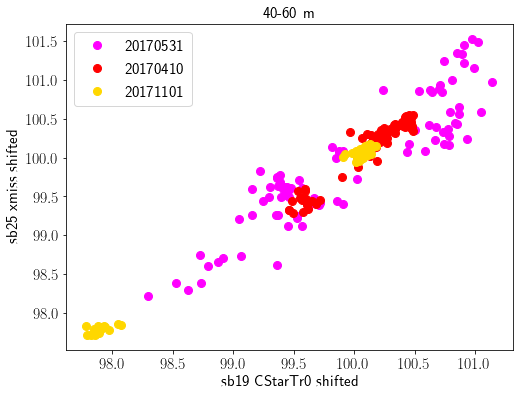

In [69]:
#divide by date:
dfall4060=dfall.loc[(dfall.prSM>60)&(dfall.prSM<70)]
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall4060.loc[(dfall4060.Date==ical)&(dfall4060.Bathy>100)]
    ax.plot(idf['CStarTr0'],idf['xmiss'],'o',color=colors[ii],label=ical)
    ax.legend()
ax.set_xlabel('sb19 CStarTr0 shifted')
ax.set_ylabel('sb25 xmiss shifted')
ax.set_title('40-60 m')

[  1.12050884 -12.21800962]


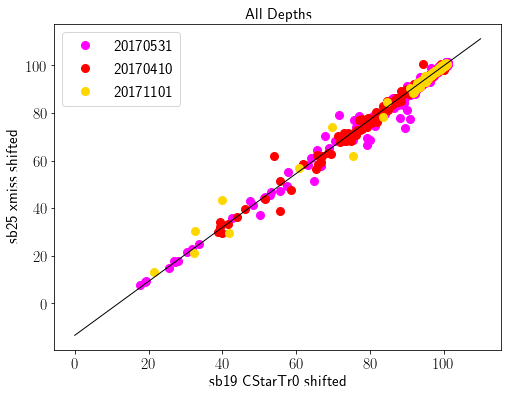

In [70]:
#divide by date:
colors='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple',
fig,ax=plt.subplots(1,1,figsize=(8,6))
for ii,ical in enumerate([20170531,20170410,20171101]):#np.unique(df['xcal0'])):
    idf=dfall.loc[(dfall.Date==ical)&(dfall.Bathy>100)]
    ax.plot(idf['CStarTr0'],idf['xmiss'],'o',color=colors[ii],label=ical)
    ax.legend()
ax.set_xlabel('sb19 CStarTr0 shifted')
ax.set_ylabel('sb25 xmiss shifted')
ax.set_title('All Depths')
ii=(~np.isnan(dfall['xmiss']))&(~np.isnan(dfall['CStarTr0']))#&(~np.isnan(dfall['NTU']))
A=np.concatenate([dfall.loc[ii,['CStarTr0']].values,np.ones((np.sum(ii),1))],1)
b=dfall.loc[ii,['xmiss']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
ax.plot((0,110),np.array((0,110))*1.13250544-13.38048429,'k-')
print(m)

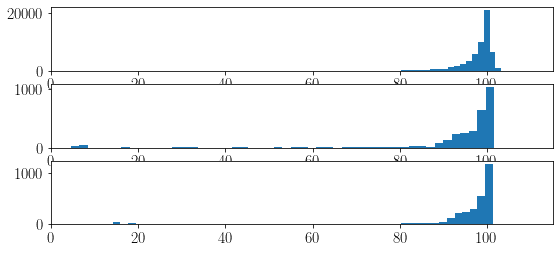

In [71]:
fig,ax=plt.subplots(3,1,figsize=(9,4))
ax[0].hist(df2[['xmiss']],100);
ax[1].hist(dfall[['xmiss']],50);
ax[2].hist(dfall[['CStarTr0']],50);
for iax in ax:
    iax.set_xlim(0,115)

## Test new code:

In [72]:
dftest=STRAT.loadSTRATOGEM_XFP()

load SSG
SG02-01 11/April/02 1.6227499999999964
SG02-02  8/May/02 -0.6704500000000024
SOG02-03 5/June/2002 -0.2139500000000112
SOG02-04 10/July/2002 0.5047999999999888
SOG02-05 17/July/2002 -0.03340000000000032
SOG02-06 07/August/2002 1.3174999999999955
SOG02-06 7/August/2002 8.0942
SOG02-07 29/Aug/2002 0.8496999999999986
SOG02-08 8/Oct/2002 1.842100000000002
SOG02-08 8/October/2002 1.5545999999999935
SOG02-09 5/Nov/2002 2.288749999999993
SOG02-10 4/Dec/2002 2.5351500000000016
SOG03-01 8/Jan/2003 1.9637500000000045
SOG03-02 5/Feb/2003 2.0537499999999937
SOG03-03 5/Mar/2003 5.672150000000002
SOG03-04 19/Mar/2003 7.4773
SOG03-05 2/Apr/2003 4.46905000000001
SOG03-06 9/Apr/2003 6.000550000000004
SOG03-07 16/Apr/2003 4.312150000000003
SOG03-08 23/Apr/2003 6.894599999999997
SOG03-09 28/May/2003 2.457250000000002
SOG03-10 19 /June/2003 3.2700999999999993
SOG03-11 23/June/2003 3.0463000000000022
SOG03-12 26 /June/2003 2.7757000000000005
SOG03-14 3 /July/2003 3.1513999999999953
SOG03-19 23/Sep/

In [73]:
dfalltest=FRP.loadFlat(exp='all',sel='wide',dp=1.0)

20170410 3.8876330419125793
20170531 4.548945890945674
20171101 6.538724156994277
